In [1]:
import sys
%load_ext autoreload
%autoreload 2
sys.path.append('..')
sys.path.append('../libseq2seq/')

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from libseq2seq import bert_model

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
%env CUDA_VISIBLE_DEVICES=1

NUM_LABELS = 54 

# terminal labels
NUM_LABELS += 4

params = {
    'num_labels': NUM_LABELS,
    'label_list': [str(label) for label in range(NUM_LABELS)],
    'output_dir': '../output',
    'cache_dir': '../model_cache',
    'bert_model': 'bert-base-uncased',
    'max_seq_length': 256,
    'train_batch_size': 16,
    'eval_batch_size': 1,
    'learning_rate': 2e-5,
    'warmup_proportion': 0.1,
    'num_train_epochs': 2,
    'seed': 1331,
    'device': torch.device(
        'cuda:0' if torch.cuda.is_available()
        else 'cpu')
}

params['lower_case'] = (params['bert_model'][-7:] == 'uncased')

env: CUDA_VISIBLE_DEVICES=1


## Preparing data

In [3]:
DATA_DIR = '../datasets'

def create_label_sets(df):
    labels = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        label_set = np.array(row['labels'].strip('[]').split(', '))
        labels.append(list(np.array(label_set[label_set != ''], dtype=int)))
    return labels

df_train = pd.read_csv(
    os.path.join(DATA_DIR, 'AAPD/train.csv'),
    encoding='utf-8')
df_valid = pd.read_csv(
    os.path.join(DATA_DIR, 'AAPD/valid.csv'),
    encoding='utf-8')
df_test = pd.read_csv(
    os.path.join(DATA_DIR, 'AAPD/test.csv'),
    encoding='utf-8')

X_train, y_train = (df_train['text'].values,
                    create_label_sets(df_train))
X_valid, y_valid = (df_valid['text'].values,
                    create_label_sets(df_valid))
X_test, y_test = (df_test['text'].values,
                  create_label_sets(df_test))

print('Train size:', len(df_train))
print('Valid size:', len(df_valid))
print('Test size: ', len(df_test))

df_train.head(n=10)

100%|██████████| 1000/1000 [00:00<00:00, 6366.35it/s]

Train size: 53840
Valid size: 1000
Test size:  1000


,text,labels
0,the relation between pearson 's correlation co...,"[20, 45]"
1,the present work studies quantum and classical...,"[0, 1, 22]"
2,one of the most important tasks in image proce...,"[15, 44]"
3,frequency diverse \( fd \) radar waveforms are...,"[0, 1, 44]"
4,unsupervised word embeddings have been shown t...,"[3, 14]"
5,a discrete time wiener phase noise channel wit...,"[0, 1]"
6,"in this paper , we consider a particular class...","[0, 1]"
7,the gallager bound is well known in the area o...,"[0, 1]"
8,symmetric tensor operations arise in a wide va...,"[32, 46]"
9,in a basic related key attack against a block ...,"[0, 1, 16, 22]"


In [4]:
import json

with open(os.path.join(DATA_DIR, 'AAPD/index_to_label.json')) as f:
    index_to_label = json.load(f)
index_to_label = {int(index): label for index, label in index_to_label.items()}

In [5]:
def convert_labels(label_indexes):
    return [index_to_label[index] for index in label_indexes]

In [6]:
import re
def create_ohe_labels(labels_column):
    labels_str = re.sub('\s+', ' ', labels_column.strip('[] ')).split(', ')
    text_labels = np.array(labels_str, dtype=int)
    text_labels
    codes = np.zeros(params['num_labels'] - 4, dtype=int)
    codes[text_labels] = 1
    return codes.tolist()

def get_data_ohe_labels(df):
    targets = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        try:
            targets.append(create_ohe_labels(row['labels']))
        except:
            print(i)
            break
    return targets

y_test_ohe = get_data_ohe_labels(df_test)
y_val_ohe = get_data_ohe_labels(df_valid)

100%|██████████| 1000/1000 [00:00<00:00, 4585.90it/s]


## Training BERT model

In [7]:
model = bert_model.BertSeq2seqModel(params)

/home/ramild/miniconda2/envs/py361/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Completed!


In [8]:
model.model.load_state_dict(torch.load('../output/model_aapd_seq2seq_v1.pth'))

In [ ]:
result = model.fit(X_train, y_train, batch_size=16, n_epochs=15,
                   validation_data=(X_valid, y_valid),
                   best_model_output='model_aapd_seq2seq_v1.pth')
result

In [12]:
from sklearn import metrics
def print_metrics(y_true, preds, threshold=0.5):
    y_true = np.array(y_true)
    y_pred = np.array(preds >= threshold, dtype=int)
    return {
        'micro_f1': metrics.f1_score(y_true, y_pred, average='micro'),
        'macro_f1': metrics.f1_score(y_true, y_pred, average='macro'),
        'accuracy': metrics.accuracy_score(y_true, y_pred),
        'hamming_accuracy': 1 - metrics.hamming_loss(y_true, y_pred)
    }

In [107]:
result_valid, preds_valid, prob_preds_valid = bert_model.evaluate_seq2seq_model(
    params, model.model, model.tokenizer, X_valid, y_valid)

{'val_log_loss': 7.157905424833298, 'val_log_loss_cmp': 1.045712991210124}
{'val_log_loss': 7.026240200400353, 'val_log_loss_cmp': 1.0355549300516362}
{'val_log_loss': 7.0662332224845885, 'val_log_loss_cmp': 1.0391519444830277}
1000 1000 1000
[[20, 38], [0, 1], [0, 1], [2, 14, 20], [0, 1, 6], [0, 1, 47], [0, 1], [8, 12], [0, 1], [12, 35]]
[[20, 38], [8, 26], [0, 1], [2, 14], [0, 1], [0, 1], [2, 45], [8, 24], [0, 1], [12, 35]]
[tensor([46, 98, 74], device='cuda:0'), tensor([ 8, 29, 35], device='cuda:0'), tensor([  4,  74, 109], device='cuda:0'), tensor([131, 174,   1], device='cuda:0'), tensor([23,  9, 73], device='cuda:0'), tensor([  2,   2, 143], device='cuda:0'), tensor([ 18,  22, 111], device='cuda:0'), tensor([14,  5, 95], device='cuda:0'), tensor([ 12, 150, 130], device='cuda:0'), tensor([52, 42, 49], device='cuda:0')]



In [13]:
result_valid

{'val_log_loss': 3.533116694688797,
 'val_log_loss_cmp': 1.0391519690261168,
 'hamming_loss': 0.025166666666666667,
 'macro_f1': 0.4704780301204323,
 'macro_precision': 0.5658158792272774,
 'macro_recall': 0.4317433142991923,
 'micro_f1': 0.6946753538530668,
 'micro_precision': 0.7537786445636275,
 'micro_recall': 0.6441666666666667,
 'accuracy_strict': 0.445,
 'accuracy_soft': 0.455,
 'accuracy_soft_1': 0.454}

In [36]:
new_preds = [np.where(np.array(prob_preds[i]) >= 0.5)[0].tolist() for i in range(1000)]

In [39]:
print_metrics(y_test_ohe, preds_test_bert)

{'micro_f1': 0.7176573426573426,
 'macro_f1': 0.5590319078662799,
 'accuracy': 0.381,
 'hamming_accuracy': 0.9760740740740741}

In [77]:
result

{'val_log_loss': 7.542940304756165,
 'val_log_loss_cmp': 1.102446697567402,
 'hamming_loss': 0.026722222222222224,
 'macro_f1': 0.4771427210385255,
 'macro_precision': 0.5870118300132183,
 'macro_recall': 0.4372658520133288,
 'micro_f1': 0.6776859504132231,
 'micro_precision': 0.7378404669260701,
 'micro_recall': 0.6266005782734407,
 'accuracy_strict': 0.407,
 'accuracy_soft': 0.417,
 'accuracy_soft_1': 0.417}

In [79]:
print_metrics(y_test_ohe, np.array(prob_preds), 0.4)

{'micro_f1': 0.6811329374143443,
 'macro_f1': 0.4646321450022095,
 'accuracy': 0.391,
 'hamming_accuracy': 0.9741481481481481}

In [103]:
print_metrics(y_test_ohe, np.array(prob_preds_beam), 0.5)

{'micro_f1': 0.657999580624869,
 'macro_f1': 0.48341728910782505,
 'accuracy': 0.273,
 'hamming_accuracy': 0.9697962962962963}

In [37]:
preds_test_bert = np.load('../output/temp_aapd256_bert_preds.npy')
preds_val_bert = np.load('../output/temp_aapd256_bert_preds_val.npy')

In [35]:
print_metrics(y_test_ohe, preds_test_bert)

/home/ramild/miniconda2/envs/py361/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'micro_f1': 0.7176573426573426,
 'macro_f1': 0.5590319078662799,
 'accuracy': 0.381,
 'hamming_accuracy': 0.9760740740740741}

In [40]:
preds_bert = [list(np.where(pred >= 0.5)[0])
              for i, pred in enumerate(preds_test_bert)]

In [41]:
preds_bert = [list(np.where(pred >= 0.5)[0])
              for i, pred in enumerate(preds_test_bert)]

In [40]:
preds_bert[:10]

[[15],
 [0, 1],
 [2, 23],
 [12, 43],
 [0, 1, 11],
 [0, 1],
 [0, 1],
 [],
 [3, 8, 23],
 [4, 7]]

In [41]:
preds[:10]

[[2, 15],
 [0, 1],
 [2, 23],
 [12, 27],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [8, 26],
 [2, 4]]

In [42]:
indexes_seq2seq_win = []
indexes_bert_win = []

In [43]:
for i, text in enumerate(X_test):
    if preds[i] == y_test[i] and preds_bert[i] != y_test[i]:
        indexes_seq2seq_win.append((i, len(set(preds[i]) ^ set(preds_bert[i]))))
    if preds[i] != y_test[i] and preds_bert[i] == y_test[i]:
        indexes_bert_win.append((i, len(set(preds[i]) ^ set(preds_bert[i]))))

In [122]:
from tqdm import tqdm_notebook as tqdm
alpha_list = np.linspace(0.0, 1.0, 1001)
metrics_list = {
    'micro_f1': [],
    'macro_f1': [],
    'accuracy': [],
    'hamming_accuracy': []
}

for alpha in tqdm(alpha_list):
    prediction_valid = prob_preds_valid * alpha + preds_val_bert * (1 - alpha)
    val_metrics = print_metrics(y_val_ohe, prediction_valid)
    for metrics_name in val_metrics:
        metrics_list[metrics_name].append(val_metrics[metrics_name])

/home/ramild/miniconda2/envs/py361/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [130]:
for metrics_name in metrics_list:
    print(metrics_name, alpha_list[np.argmax(metrics_list[metrics_name])], max(metrics_list[metrics_name]))

micro_f1 0.231 0.7489361702127659
macro_f1 0.231 0.5696400211643575
accuracy 0.23 0.451
hamming_accuracy 0.424 0.9793148148148149


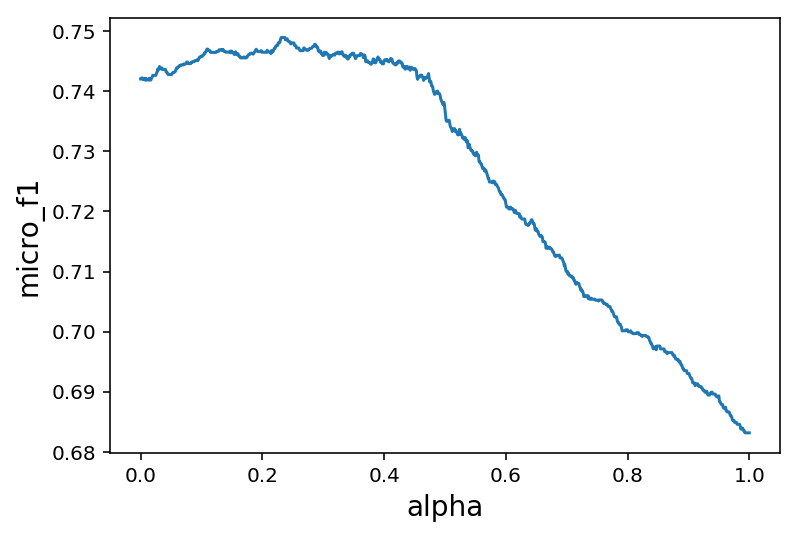

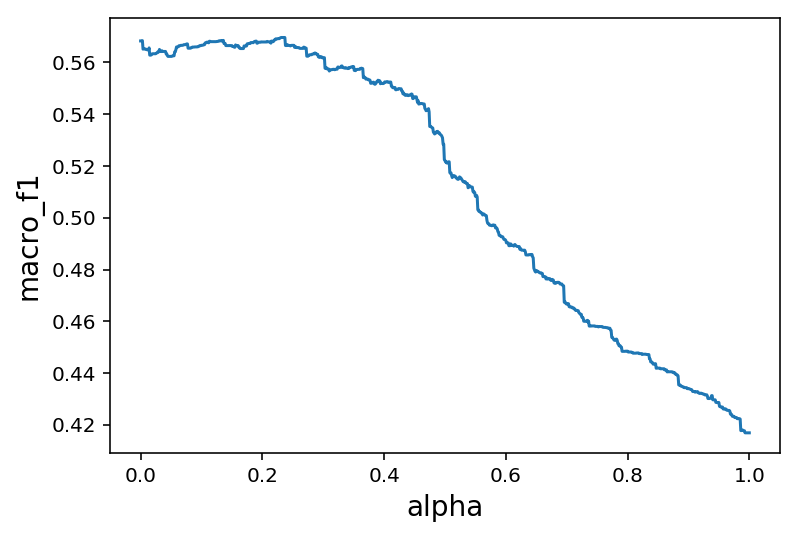

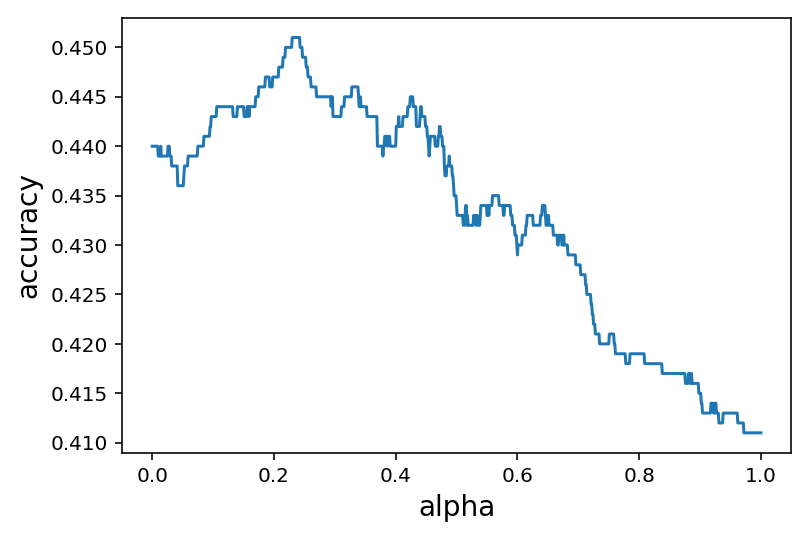

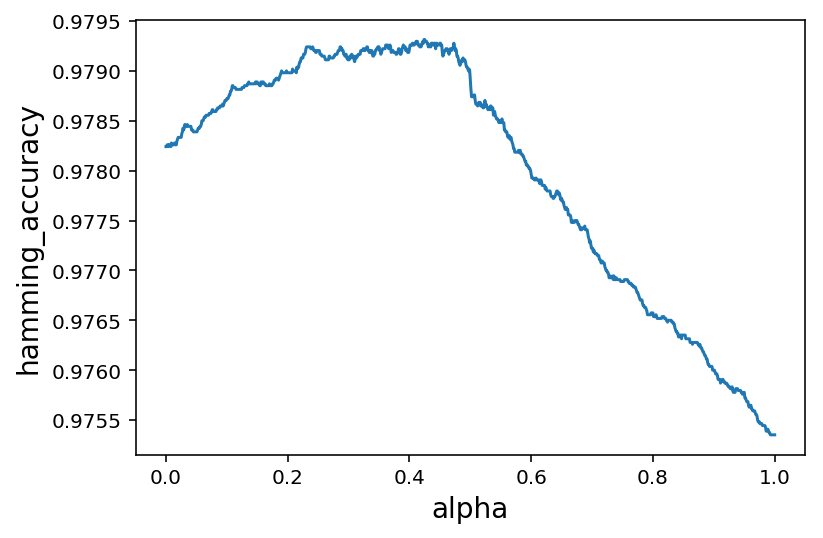

In [158]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt

for metrics_name in metrics_list:
    plt.plot(alpha_list, metrics_list[metrics_name])
    plt.xlabel('alpha', fontsize=14)
    plt.ylabel(metrics_name, fontsize=14)
    plt.show()

In [138]:
best_alpha = 0.231
prob_preds_test = np.array(prob_preds)
prediction_test = prob_preds_test * best_alpha + preds_test_bert * (1 - best_alpha)

In [143]:
print_metrics(y_test_ohe, prediction_test)

/home/ramild/miniconda2/envs/py361/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'micro_f1': 0.719427677174156,
 'macro_f1': 0.5524668122173447,
 'accuracy': 0.397,
 'hamming_accuracy': 0.9767592592592592}

In [144]:
print_metrics(y_test_ohe, prob_preds_test)

{'micro_f1': 0.665551839464883,
 'macro_f1': 0.42403396577343205,
 'accuracy': 0.377,
 'hamming_accuracy': 0.9740740740740741}

In [145]:
print_metrics(y_test_ohe, preds_test_bert)

{'micro_f1': 0.7176573426573426,
 'macro_f1': 0.5590319078662799,
 'accuracy': 0.381,
 'hamming_accuracy': 0.9760740740740741}

In [16]:
print_metrics(y_test_ohe, prob_preds)

/home/ramild/miniconda2/envs/py361/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'micro_f1': 0.6650729141764284,
 'macro_f1': 0.4220101136489358,
 'accuracy': 0.377,
 'hamming_accuracy': 0.9740555555555556}

In [122]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt

def explain(model, tokenizer, sample):
    """ Computes the effect each word had on model predictions """
    
    # compute model prediction on sample (scalar float log-salary)
    _, _, baseline_pred = bert_model.evaluate_seq2seq_model(
        params, model, tokenizer, [sample], [[]], verbose=False)
    
    # for each i-th token in :col_name:, compute predictions on a copy of data
    # where i-th token is dropped (UNK)
    predictions_without_word = []
    tokens = sample.split()
    for i, token in enumerate(tokens):
        new_tokens = tokens[:]
        new_tokens[i] = ''
        new_sample = ' '.join(tokens[:i] + tokens[i + 1:])
        print(new_sample)
        _, _, new_pred = bert_model.evaluate_seq2seq_model(
            params, model, tokenizer, [new_sample], [[]], verbose=False)
        predictions_without_word.append(new_pred[0])
    
    score_differences = [
        sum(np.abs(prediction - baseline_pred[0])) for prediction in predictions_without_word
    ]
    return baseline_pred, [(token, score) for token, score in zip(tokens, score_differences)]



from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap('bwr_r'), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        #print(rgba)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html

class NoStdStreams(object):
    def __init__(self,stdout = None, stderr = None):
        self.devnull = open(os.devnull,'w')
        self._stdout = stdout or self.devnull or sys.stdout
        self._stderr = stderr or self.devnull or sys.stderr

    def __enter__(self):
        self.old_stdout, self.old_stderr = sys.stdout, sys.stderr
        self.old_stdout.flush(); self.old_stderr.flush()
        sys.stdout, sys.stderr = self._stdout, self._stderr

    def __exit__(self, exc_type, exc_value, traceback):
        self._stdout.flush(); self._stderr.flush()
        sys.stdout = self.old_stdout
        sys.stderr = self.old_stderr
        self.devnull.close()

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)
        
def draw_heatmap(model, tokenizer, sample):
    with NoStdStreams():
        pred, tokens_and_weights = explain(model, tokenizer, sample)
        weights = [weight for word, weight in tokens_and_weights]
        draw_html([(tok, weights[i] * weights[i])
                   for i, (tok, weight) in enumerate(tokens_and_weights)], font_style='font-size:14px;');

In [58]:
sample = 'Our research work is on object detection'
sample_nlp = 'Our research work is on natural language processing for sequence to sequence modeling'

In [87]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [90]:
sample_bert = 'We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations by jointly conditioning on both left and right context in all layers.'
sample_bert = ' '.join(tokenizer.tokenize(sample_bert))
sample_bert

'we introduce a new language representation model called bert , which stands for bidirectional encoder representations from transformers . unlike recent language representation models , bert is designed to pre - train deep bidirectional representations by jointly conditioning on both left and right context in all layers .'

In [98]:
draw_heatmap(model.model, model.tokenizer, sample_bert)
convert_labels(preds_sample[0])

we introduce a new language representation model called bert , which stands for bidirectional encoder representations from transformers . unlike recent language representation models , bert is designed to pre - train deep bidirectional representations by jointly conditioning on both left and right context in all layers .

['cs.LG', 'cs.CL']

In [123]:
draw_heatmap(model.model, model.tokenizer, sample_bert)
convert_labels(preds_sample[0])

we introduce a new language representation model called bert , which stands for bidirectional encoder representations from transformers . unlike recent language representation models , bert is designed to pre - train deep bidirectional representations by jointly conditioning on both left and right context in all layers .

['cs.LG', 'cs.CL']

In [79]:
draw_heatmap(model.model, model.tokenizer, X_test[76])

we discuss inequalities holding between the vocabulary size , i e , the number of distinct nonterminal symbols in a grammar based compression for a string , and the excess length of the respective universal code , i e , the code based analog of algorithmic mutual information the aim is to strengthen inequalities which were discussed in a weaker form in linguistics but shed some light on redundancy of efficiently computable codes the main contribution of the paper is a construction of universal grammar based codes for which the excess lengths can be bounded easily

In [36]:
draw_heatmap(model.model, model.tokenizer, X_test[76])

we discuss inequalities holding between the vocabulary size , i e , the number of distinct nonterminal symbols in a grammar based compression for a string , and the excess length of the respective universal code , i e , the code based analog of algorithmic mutual information the aim is to strengthen inequalities which were discussed in a weaker form in linguistics but shed some light on redundancy of efficiently computable codes the main contribution of the paper is a construction of universal grammar based codes for which the excess lengths can be bounded easily